# Sequence Classification using Recurrent Neural Networks(RNN)
In this homework, you will learn how to train a recurrent neural network for human action classification. RNN is designed handle sequential data. The network can incorporate both past history and current input. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a very good tutorial. You should read it before you start.

## Setup
Please make sure you have h5py and torchnet installed
> pip install h5py

> pip install git+https://github.com/pytorch/tnt.git@master


In [2]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

use cuda: True


## Dataset
The data we are using is skeleton data, which indicates the 3D locations of body joints. In total, there are 25 body joints. It is collected by Kinect v2. To make it easier, each sequence have same number of frames. You need to classify 10 different actions. There are 2000 training sequences, 400 validation sequences, and 500 test sequences. Each sequence has 15 frames, each frame is a 75-dimension vector (3*25).

For your convenience, we provide the dataloader for you.


In [3]:
class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_path, subset='train'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s_data.h5'%subset)
        self.subset = subset

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['data'])

        if subset != 'test':
            self.label_path = os.path.join(data_path, '%s_label.h5'%subset)
            with h5py.File(self.label_path) as f:
                self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        if self.subset != 'test':
            label = int(self.label[index])
            sample = {'seq': seq, 'label': label}
        else:
            sample = {'seq': seq}
        return sample

    def __len__(self):
        return self.num_sequences

trSet = Dataset('./data', subset='train')
valSet = Dataset('./data', subset='val')
tstSet = Dataset('./data', subset='test')

batch_size = 50
trLD = DD.DataLoader(trSet, batch_size=batch_size, sampler=DD.sampler.RandomSampler(trSet), 
                     num_workers=8, pin_memory=False)

valLD = DD.DataLoader(valSet, batch_size=batch_size, sampler=DD.sampler.SequentialSampler(valSet),
                      num_workers=8, pin_memory=False)

tstLD = DD.DataLoader(tstSet, batch_size=batch_size, sampler=DD.sampler.SequentialSampler(tstSet),
                      num_workers=8, pin_memory=False)

input_dim = trSet.n_dim
num_class = 10

In [4]:
trSet.data.shape

(2000, 15, 75)

## Model
Pytorch has implemented different types of recurrent layers for you. For this homework, you can use any type of RNNs as you want:
> torch.nn.RNN()

> torch.nn.LSTM()

> torch.nn.GRU()

You can check details for different types of recurrent layers here: [RNN](http://pytorch.org/docs/master/nn.html#torch.nn.RNN), [LSTM]( http://pytorch.org/docs/master/nn.html#torch.nn.LSTM), [GRU](http://pytorch.org/docs/master/nn.html#torch.nn.GRU)


### Implement a specific model
In this section, you need to implement a model for sequence classification. The model has following layers:
* A linear layer that can map features of 75-dimension to 100-dimension.
* 1 Layer LSTM layer with hidden size of 100
* A linear layer that goes from 100 to num_class (10). 

An LSTM layer takes an input of size of (batch_size, seq_len, fea_dim) and outputs a variable of shape (batch_size, seq_len, hidden_size). In this homework, the classification score for a sequence is the classification score for the last step of rnn_outputs.



## Note that this specific model is a very poor model

In [66]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        ############## 1st To Do (10 points) ##############
        ###################################################
        self.project_layer = nn.Linear(75, 100)
        self.recurrent_layer = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)
        self.classify_layer = nn.Linear(100, 10)
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(self.project_layer(input))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs[:, -1])
        return logits

model = SequenceClassify()
model.cuda()

SequenceClassify(
  (project_layer): Linear(in_features=75, out_features=100, bias=True)
  (recurrent_layer): LSTM(100, 100, batch_first=True)
  (classify_layer): Linear(in_features=100, out_features=10, bias=True)
)

## Train the model
After you have the dataloader and model, you can start training the model. Define a SGD optimizer with learning rate of 1e-3, and a cross-entropy loss function:

In [67]:
################ 2nd To Do  (5 points)##################
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().cuda()

In [68]:
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        #print(output_logits.size())
        #print(output_logits)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)


    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    return confusion_matrix, acc, meter_loss  


In [69]:
confusion_matrix, acc, meter_loss = None, None, None

num_epochs = 100
evaluate_every_epoch = 5
for e in range(num_epochs):
    confusion_matrix, acc, meter_loss = run_epoch(trLD, model, criterion, e, True, optimizer)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model, criterion, e, False, None) 

train Epoch: 0  , Loss: 2.3107,  Accuracy: 11.00
val Epoch: 0  , Loss: 2.3104,  Accuracy: 12.25
train Epoch: 1  , Loss: 2.3095,  Accuracy: 10.95
train Epoch: 2  , Loss: 2.3085,  Accuracy: 10.85
train Epoch: 3  , Loss: 2.3075,  Accuracy: 11.00
train Epoch: 4  , Loss: 2.3067,  Accuracy: 11.50
train Epoch: 5  , Loss: 2.3059,  Accuracy: 11.05
val Epoch: 5  , Loss: 2.3051,  Accuracy: 13.00
train Epoch: 6  , Loss: 2.3052,  Accuracy: 11.15
train Epoch: 7  , Loss: 2.3046,  Accuracy: 11.70
train Epoch: 8  , Loss: 2.3040,  Accuracy: 11.30
train Epoch: 9  , Loss: 2.3035,  Accuracy: 11.50
train Epoch: 10  , Loss: 2.3031,  Accuracy: 11.00
val Epoch: 10  , Loss: 2.3017,  Accuracy: 12.75
train Epoch: 11  , Loss: 2.3027,  Accuracy: 11.20
train Epoch: 12  , Loss: 2.3023,  Accuracy: 11.40
train Epoch: 13  , Loss: 2.3019,  Accuracy: 11.40
train Epoch: 14  , Loss: 2.3016,  Accuracy: 11.35
train Epoch: 15  , Loss: 2.3012,  Accuracy: 11.25
val Epoch: 15  , Loss: 2.2996,  Accuracy: 12.25
train Epoch: 16  , L

Traceback (most recent call last):
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor


train Epoch: 72  , Loss: 2.2884,  Accuracy: 16.00
train Epoch: 73  , Loss: 2.2881,  Accuracy: 16.50
train Epoch: 74  , Loss: 2.2878,  Accuracy: 15.80
train Epoch: 75  , Loss: 2.2875,  Accuracy: 16.60
val Epoch: 75  , Loss: 2.2839,  Accuracy: 18.00
train Epoch: 76  , Loss: 2.2871,  Accuracy: 16.55
train Epoch: 77  , Loss: 2.2868,  Accuracy: 16.80
train Epoch: 78  , Loss: 2.2865,  Accuracy: 16.90
train Epoch: 79  , Loss: 2.2862,  Accuracy: 16.45
train Epoch: 80  , Loss: 2.2858,  Accuracy: 17.15
val Epoch: 80  , Loss: 2.2820,  Accuracy: 18.75
train Epoch: 81  , Loss: 2.2855,  Accuracy: 17.35
train Epoch: 82  , Loss: 2.2851,  Accuracy: 16.65
train Epoch: 83  , Loss: 2.2847,  Accuracy: 17.25


Traceback (most recent call last):
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/wings/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor


train Epoch: 84  , Loss: 2.2843,  Accuracy: 17.30
train Epoch: 85  , Loss: 2.2839,  Accuracy: 17.65
val Epoch: 85  , Loss: 2.2797,  Accuracy: 19.50
train Epoch: 86  , Loss: 2.2835,  Accuracy: 17.30
train Epoch: 87  , Loss: 2.2831,  Accuracy: 17.85
train Epoch: 88  , Loss: 2.2827,  Accuracy: 17.50
train Epoch: 89  , Loss: 2.2822,  Accuracy: 17.85
train Epoch: 90  , Loss: 2.2817,  Accuracy: 18.25
val Epoch: 90  , Loss: 2.2770,  Accuracy: 20.50
train Epoch: 91  , Loss: 2.2812,  Accuracy: 17.90
train Epoch: 92  , Loss: 2.2807,  Accuracy: 17.70
train Epoch: 93  , Loss: 2.2802,  Accuracy: 18.05
train Epoch: 94  , Loss: 2.2796,  Accuracy: 18.30
train Epoch: 95  , Loss: 2.2790,  Accuracy: 18.45
val Epoch: 95  , Loss: 2.2738,  Accuracy: 21.00
train Epoch: 96  , Loss: 2.2784,  Accuracy: 18.30
train Epoch: 97  , Loss: 2.2778,  Accuracy: 18.70
train Epoch: 98  , Loss: 2.2772,  Accuracy: 18.40
train Epoch: 99  , Loss: 2.2764,  Accuracy: 18.90


## Submit your results on Kaggle

### Train a better model for action recognition!
Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition validation set.


### Testing the model and submit on Kaggle
Testing the model on the testing set and save the results as a .csv file. 
Please submitted the results.csv file generated by predict_on_test() to Kaggle(https://www.kaggle.com/t/934b80879bd741e6ac1967195604d4d9) to see how well your network performs on the test set. 
################ 3rd To Do  (20 points, the highest 3 entries get extra 10 points) ###############


In [45]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=200, num_layers=2, batch_first=True)
        self.classify_layer = nn.Linear(200*15, 10)
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs.reshape(batch_size, -1))
        return logits

model = SequenceClassify()
model.cuda()

SequenceClassify(
  (recurrent_layer): LSTM(75, 200, num_layers=2, batch_first=True)
  (classify_layer): Linear(in_features=3000, out_features=10, bias=True)
)

In [46]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss().cuda()

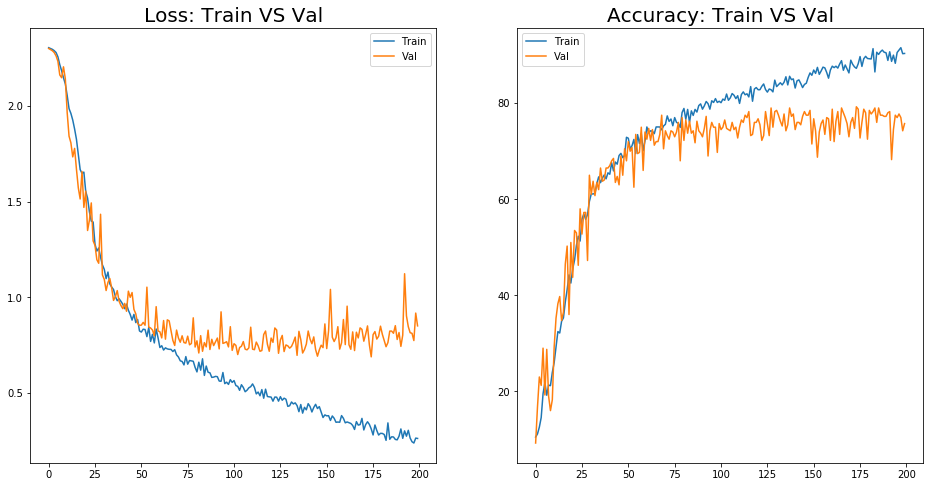

In [47]:
train_loss = []
train_acc  = []
val_loss   = []
val_acc    = []
PATH = './models/best_model_{}.pt'

best_acc = 0
num_epochs = 200
for e in range(num_epochs):
    t_l, t_a = run_epoch(trLD, model, criterion, e, True, optimizer)
    train_loss.append(t_l)
    train_acc.append(t_a)
    
    v_l, v_a = run_epoch(valLD, model, criterion, e, False, None)
    val_loss.append(v_l)
    val_acc.append(v_a)
    if v_a > best_acc:
        best_acc = v_a
        torch.save(model, PATH.format(str(v_a)))
    
    clear_output(True)
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Loss: Train VS Val', fontsize=20)
    plt.legend(['Train', 'Val'])
    plt.subplot(122)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Accuracy: Train VS Val', fontsize=20)
    plt.legend(['Train', 'Val'])
    plt.show()

In [42]:
optimizer.param_groups[0]['lr']

0.01

In [37]:
optimizer.param_groups[0]['momentum'] = 0.8

In [9]:
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        #print(output_logits.size())
        #print(output_logits)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)


    #print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    return meter_loss.value()[0], acc.value()[0]
 

In [8]:
# Use your best model to generate results on test set.

# generate csv file for test set
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i].item())+'\n')
            count+=1
    results.close()
    return count


In [48]:
model_load = torch.load('./models/best_model_81.0.pt')
count=predict_on_test(model_load, tstLD)
print(count)

1000


/home/wings/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  del sys.path[0]


## Report the performance
################ 4th To Do  (5 points)##################

In this cell, you should write an explanation of what you did (network architecture, optimiziter, learning rate, epochs) and any visualizations or graphs that you make in the process of training and evaluating your network.

Report your Kaggle Performance here:

### 1. Increase hidden_size to {200, 400}
### 2. Add a second LSTM layer
### 3. Add dropout {0.2, 0.5}

## version 0.1.x

In [59]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        self.recurrent_layer = nn.LSTM(input_size=75, hidden_size=400, num_layers=2, dropout=0.5, batch_first=True)
        self.classify_layer = nn.Linear(400, 10)
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, seq_len]
        logits = self.classify_layer(rnn_outputs[:, -1])
        return logits

model = SequenceClassify()
model.cuda()

SequenceClassify(
  (recurrent_layer): LSTM(75, 400, num_layers=2, batch_first=True, dropout=0.5)
  (classify_layer): Linear(in_features=400, out_features=10, bias=True)
)